In [11]:
%matplotlib notebook

In [1]:
from stemutils.io import *
import json

In [2]:
fdp = Path('/dls/science/groups/imaging/ePSIC_students/Andy_Bridger/mg28034-1/processing/Merlin/Calibrated/O3_pure')

dps = [dp for dp in fdp.walk('.hdf5','binned', max_depth =1) if len(dp.parent.walk('FullModel', max_depth =3)) ==1]

hparams = {'KN1':32,'KN2':64,'KN3':128, 'KN4':128, 'KN5':256,'D1':128,'D2':512,'LAT':2,'LR':0.0001, 'B':1}

n_epochs = 2


In [3]:
dp = dps[0]

In [4]:
dp

Path('/dls/science/groups/imaging/ePSIC_students/Andy_Bridger/mg28034-1/processing/Merlin/Calibrated/O3_pure/20210305 115625/20210305_115625.hdf5')

In [5]:
old_model_weights = best_model_from_list(dp.redirect('FullModel', 1).ls())

In [6]:
old_model_weights

Path('/dls/science/groups/imaging/ePSIC_students/Andy_Bridger/mg28034-1/processing/Merlin/Calibrated/O3_pure/20210305 115625/FullModel/chk-1996-1.87809e+03.hdf5')

In [7]:
#load some packages in
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import random as python_random
from numba import njit
from tensorboard.plugins.hparams import api as hp
from stemutils.io import Path
import hyperspy.api as hs
import concurrent.futures
from skimage.transform import resize
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from functools import lru_cache
from stemseg.processing_funcs import *

#set some variables
print('Using TensorFlow v%s' % tf.__version__)
plt.style.use('default')


#define some functions

###################################################
########### Data Preprocessing ####################
###################################################

def batch_resize(d, bs=512):
    if len(d.shape) == 4:
        flat_d = flatten_nav(d)
    else:
        flat_d = d
    n_batches = int(np.ceil(flat_d.shape[0]//bs))
    batches = [flat_d[i*bs:(i+1)*bs] for i in range(n_batches+1)]
    if len(batches[-1])==0:
        batches.pop(-1)
    print(len(batches[-1]))
    with concurrent.futures.ProcessPoolExecutor(max_workers=4) as exe:
        res = [exe.submit(resize, batch, (batch.shape[0],128,128)) for batch in batches]
    r_batches = [f.result() for f in res]
    return np.concatenate(r_batches, axis = 0).reshape((d.shape[0],128,128))

def data_manip(d, bs = 512):
    if type(d) != np.ndarray:
        print('dask to numpy')
        d = d.compute()
        print('dask to numpy done')
    print('started data manipulations')
    #d = resize(d,(d.shape[0],128,128))
    print('resized')
    d = d.astype('float32')
    for i in range(d.shape[0]):
        d_max = np.max(d[i])
        d[i] = d[i]/d_max
    d = batch_resize(d, bs)
    scaler = np.log(1001)
    return np.log((d*1000)+1)/scaler 


def data_manip_lowq(d, central_box = 128):
    pxc, pyc = d.shape[1]//2, d.shape[2]//2 
    pxl, pxu = pxc - central_box//2, pxc + central_box//2 
    pyl, pyu = pyc - central_box//2, pyc + central_box//2 

    d = d[:, pxl:pxu, pyl:pyu]
    if type(d) != np.ndarray:
        print('dask to numpy')
        d = d.compute()
        print('dask to numpy done')
    print('started data manipulations')
    #d = resize(d,(d.shape[0],128,128))
    print('resized')
    d = d.astype('float32')
    for i in range(d.shape[0]):
        d_max = np.max(d[i])
        d[i] = d[i]/d_max

    scaler = np.log(1001)
    return np.log((d*1000)+1)/scaler 


###################################################
###################################################
###################################################

def flatten_nav(sig):
    shape = [sig.shape[0]*sig.shape[1]]
    for i in sig.shape[2:]:
        shape.append(i)
    return sig.reshape(shape)


class My_Custom_Generator(keras.utils.Sequence) :
    def __init__(self, image_filenames,  batch_size) :
        self.image_filenames = image_filenames
        self.batch_size = batch_size

    def __len__(self) :
        return (np.ceil(len(self.image_filenames) / float(self.batch_size))).astype(np.int)


    @lru_cache(None)
    def __getitem__(self, idx) :
        batch_x = self.image_filenames[idx * self.batch_size : (idx+1) * self.batch_size]
        out_img = np.asarray([np.load(file_name)[:,:,None] for file_name in batch_x])
        return out_img, out_img
        #return batch_x, batch_y


class Array_Generator(keras.utils.Sequence) :
    def __init__(self, images,  batch_size, target = 'same') :
        self.images = images
        self.batch_size = batch_size
        if target == 'same':
            self.target = images
        else:
            self.target = target

    def __len__(self) :
        return (np.ceil(len(self.images) / float(self.batch_size))).astype(np.int)


    @lru_cache(None)
    def __getitem__(self, idx) :
        out_img = self.images[idx * self.batch_size : (idx+1) * self.batch_size, :,:,None]
        out_targ = self.target[idx * self.batch_size : (idx+1) * self.batch_size, :,:,None]
        return out_img, out_targ
        #return batch_x, batch_y

class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.keras.backend.random_normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

def create_vae_model(hparams):

    n_img = 128
    latent_dim = hparams['LAT']
    beta = hparams['B']

    image_input = keras.Input(shape=(n_img, n_img,1), name = 'enc_input')
    x = layers.Conv2D(hparams['KN1'],5, strides = 2, activation='relu',padding='same', input_shape=image_input.shape, name = 'enc_conv1')(image_input)
    x = layers.Conv2D(hparams['KN2'],5, strides = 2, activation='relu',padding='same', name = 'enc_conv2')(x)
    x = layers.Conv2D(hparams['KN3'],5, strides = 2, activation='relu',padding='same', name = 'enc_conv3')(x)
    x = layers.Conv2D(hparams['KN4'],5, strides = 2, activation='relu',padding='same', name = 'enc_conv4')(x)
    x = layers.Conv2D(hparams['KN5'],5, strides = 2, activation='relu',padding='same', name = 'enc_conv5')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(hparams['D1'], activation='relu', name = 'enc_d1')(x)
    x = layers.Dense(hparams['D2'], activation="relu", name = 'enc_d2_t')(x)
    x = layers.Dense(hparams['D2'], activation="relu", name = 'enc_d3_t')(x)
    x = layers.Dense(hparams['D2'], activation="relu", name = 'enc_d4_t')(x)
    x = layers.Dense(hparams['D2'], activation="relu", name = 'enc_d5_t')(x)
    x = layers.Dense(hparams['D2'], activation="relu", name = 'enc_d6_t')(x)
    x = layers.Dense(hparams['D2'], activation="relu", name = 'enc_d7_t')(x)
    x = layers.Dense(hparams['D2'], activation="relu", name = 'enc_d8_t')(x)
    z_mean = layers.Dense(latent_dim, name="z_mean_t")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var_t")(x)
    z_output = Sampling()([z_mean, z_log_var])
    encoder_VAE = keras.Model(image_input, [z_mean, z_log_var, z_output])

    z_input = keras.Input(shape=(latent_dim,), name = 'dec_input_t')
    x = layers.Dense(hparams['D2'], activation="relu", name = 'dec_d1_t')(z_input)
    x = layers.Dense(hparams['D2'], activation="relu", name = 'dec_d2')(x)
    x = layers.Dense(hparams['D2'], activation="relu", name = 'dec_d3')(x)
    x = layers.Dense(hparams['D2'], activation="relu", name = 'dec_d4')(x)
    x = layers.Dense(hparams['D2'], activation="relu", name = 'dec_d5')(x)
    x = layers.Dense(hparams['D2'], activation="relu", name = 'dec_d6')(x)
    x = layers.Dense(hparams['D1'], activation="relu", name = 'dec_d7')(x)
    x = layers.Dense(4*4*hparams['KN5'], activation="relu", name = 'dec_d8')(x)
    x = layers.Reshape((4, 4,hparams['KN5']))(x)
    x = layers.Conv2DTranspose(hparams['KN4'],5, strides = 2, activation='relu',padding='same', name = 'dec_conv1')(x)
    x = layers.Conv2DTranspose(hparams['KN3'],5, strides = 2, activation='relu',padding='same', name = 'dec_conv2')(x)
    x = layers.Conv2DTranspose(hparams['KN2'],5, strides = 2, activation='relu',padding='same', name = 'dec_conv3')(x)
    x = layers.Conv2DTranspose(hparams['KN1'],5, strides = 2, activation='relu',padding='same', name = 'dec_conv4')(x)
    image_output = layers.Conv2DTranspose(1,5, strides = 2, activation='sigmoid',padding='same', name = 'dec_conv5')(x)
    #image_output = layers.Conv2DTranspose(16,3, strides = 2, activation='sigmoid',padding='same')
    #image_output = layers.Reshape((n_img, n_img,1))(x)
    decoder_VAE = keras.Model(z_input, image_output)

    # VAE class
    class VAE(keras.Model):
        # constructor
        def __init__(self, encoder, decoder, **kwargs):
            super(VAE, self).__init__(**kwargs)
            self.encoder = encoder
            self.decoder = decoder

        # customise train_step() to implement the loss 
        def train_step(self, x):
            if isinstance(x, tuple):
                x = x[0]
            with tf.GradientTape() as tape:
                # encoding
                z_mean, z_log_var, z = self.encoder(x)
                # decoding
                x_prime = self.decoder(z)
                # reconstruction error by binary crossentropy loss
                reconstruction_loss = tf.reduce_mean(keras.losses.binary_crossentropy(x, x_prime)) * n_img * n_img
                # KL divergence
                kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
                # loss = reconstruction error + KL divergence
                loss = reconstruction_loss + beta* kl_loss
            # apply gradient
            grads = tape.gradient(loss, self.trainable_weights)
            self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
            # return loss for metrics log
            return {"loss": loss}


        def call(self, x):
            if isinstance(x, tuple):
                x = x[0]
            # encoding
            z_mean, z_log_var, z = self.encoder(x)
            # decoding
            x_prime = self.decoder(z)
            return x_prime
    # build the VAE
    vae_model = VAE(encoder_VAE, decoder_VAE)

    # compile the VAE
    vae_model.compile(optimizer=keras.optimizers.Adam(learning_rate=hparams['LR']),loss=custom_loss)
    vae_model.build((1,128,128,1))

    return vae_model



def custom_loss(x,y):
    n_img = 128
    return tf.reduce_mean(keras.losses.binary_crossentropy(x, y)) * n_img * n_img


print(tf.config.list_physical_devices())



2022-08-19 10:41:56.617433: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


Using TensorFlow v2.3.0


/dls_sw/apps/python/anaconda/4.6.14/64/envs/epsic3.7/lib/python3.7/site-packages/pyUSID/viz/__init__.py:18: FutureWarning: Please use sidpy.viz.plot_utils instead of pyUSID.viz.plot_utils. pyUSID.plot_utils will be removed in a future release of pyUSID
  FutureWarning)


Using TensorFlow v2.3.0
Using TensorFlow v2.3.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'), PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2022-08-19 10:42:09.290991: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2022-08-19 10:42:09.292498: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:d8:00.0 name: Tesla V100-PCIE-32GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-08-19 10:42:09.292524: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2022-08-19 10:42:09.292596: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2022-08-19 10:42:09.292622: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10
2022-08-19 10:42:09.292645: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcurand.so

In [8]:
mp = dp.redirect('RefinedModel')
if not mp.exists():
    mp.mkdir()
print(mp)

### Load in the Data

sample = ProcessedSample(dp, 'Test')

### Create a dictionary to hold some useful information

info = {}

nds = flatten_nav(sample.raw_data.data)

ds = hs.load(dp)

sx, sy = ds.data.shape[2:]

from skimage.measure import shannon_entropy

entropy = np.zeros((sample.raw_data.data.shape[0:2]))

for i in range(ds.data.shape[0]):
    print(i)
    for j in range(ds.data.shape[1]):
        entropy[i,j] = shannon_entropy(ds.data[i,j,sx//2-128:sx//2+128, sy//2-128:sy//2+128])

data_patterns = flatten_nav(ds.data)

entr = flatten_nav(entropy**3)

sl_pdf = entr/ entr.sum()



sdps = data_patterns[np.random.choice(np.arange(data_patterns.shape[0]), 5000, True, sl_pdf)]


def data_manip_lowq_resized(d, central_box = 256, bs = 256):
    pxc, pyc = d.shape[1]//2, d.shape[2]//2 
    pxl, pxu = pxc - central_box//2, pxc + central_box//2 
    pyl, pyu = pyc - central_box//2, pyc + central_box//2 

    d = d[:, pxl:pxu, pyl:pyu]
    if type(d) != np.ndarray:
        print('dask to numpy')
        d = d.compute()
        print('dask to numpy done')
    print('started data manipulations')
    #d = resize(d,(d.shape[0],128,128))
    print('resized')
    d = d.astype('float32')
    for i in range(d.shape[0]):
        d_max = np.max(d[i])
        d[i] = d[i]/d_max
    d = batch_resize(d, bs)
    scaler = np.log(1001)
    return np.log((d*1000)+1)/scaler 



input_data = data_manip_lowq_resized(nds)
np.random.shuffle(input_data)
#input_targets = data_manip_lowq(nlds)
val_data = data_manip_lowq_resized(sdps)
np.random.shuffle(val_data)



##### Otherwise just skip

print(input_data.shape)

batch_size = 2048

train_gen = Array_Generator(input_data, batch_size)#, target = input_targets)
valid_gen = Array_Generator(val_data, batch_size)

batch_shape = train_gen[0][0].shape
input_shape = (batch_shape[1],batch_shape[2],batch_shape[3])
out_dims = int(train_gen[0][1].shape[1])

### Check the training data

rand_patt = np.random.randint(0, len(input_data))

### Set the checkpointing

chkpoint_filepath = str(mp)+'/chk-{epoch:02d}-{val_loss:.5e}.hdf5'
chkpoint_model = tf.keras.callbacks.ModelCheckpoint(
    filepath = chkpoint_filepath,
    monitor="val_loss",
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode="min",
    save_freq="epoch",
    options=None)

### Redefine the model parameters if you want

rebin_factor = 1

sample_name = 'full'

### Train the Model

/dls/science/groups/imaging/ePSIC_students/Andy_Bridger/mg28034-1/processing/Merlin/Calibrated/O3_pure/20210305 115625/RefinedModel
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
24

In [32]:
str(dp).replace('.hdf5', '_fixed.hdf5')

'/dls/science/groups/imaging/ePSIC_students/Andy_Bridger/mg28034-1/processing/Merlin/Calibrated/O3_pure/20210305 115625/20210305_115625_fixed.hdf5'

In [33]:
for dp in dps:
    ds = hs.load(dp)
    new_ds = ds.inav[:,1:]
    new_ds.save(str(dp).replace('.hdf5', '_fixed.hdf5'), overwrite= True)
    del ds, new_ds

In [35]:
for dp in dps:
    fixed_path = Path(str(dp).replace('.hdf5', '_fixed.hdf5'))
    dp.unlink()
    fixed_path.rename(dp)

In [34]:
dp.rename()

Path('/dls/science/groups/imaging/ePSIC_students/Andy_Bridger/mg28034-1/processing/Merlin/Calibrated/O3_pure/20210305 132349/20210305_132349.hdf5')

[########################################] | 100% Completed | 28.0s


<IPython.core.display.Javascript object>


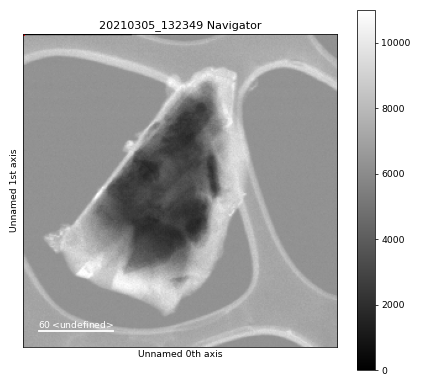

<IPython.core.display.Javascript object>


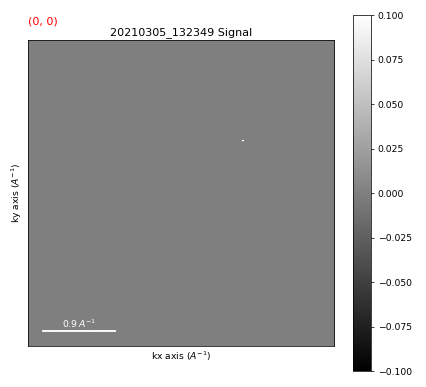

In [26]:
ds.plot()

In [27]:
new_ds = ds.inav[:,1:]

[########################################] | 100% Completed | 32.0s


<IPython.core.display.Javascript object>


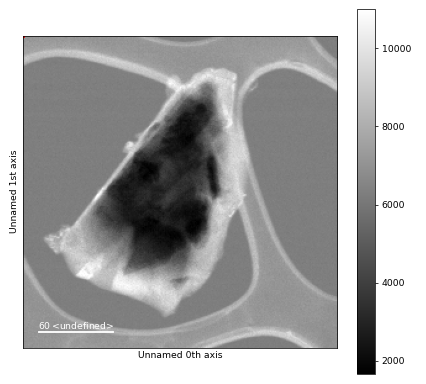

<IPython.core.display.Javascript object>


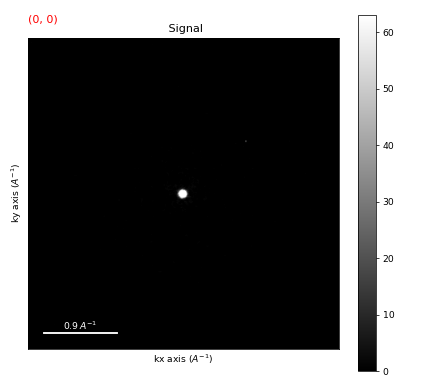

In [28]:
new_ds.plot()

[########################################] | 100% Completed |  0.3s


<IPython.core.display.Javascript object>


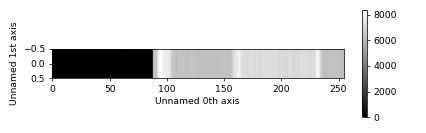

<IPython.core.display.Javascript object>


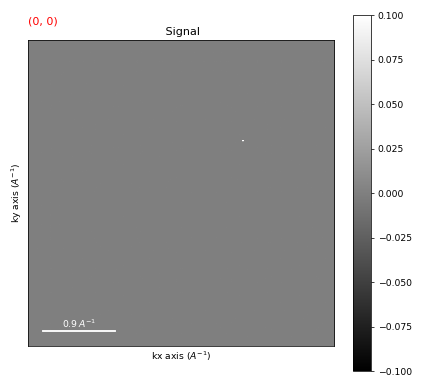

In [25]:
ds.inav[:,:1].plot()

[########################################] | 100% Completed |  0.3s


<IPython.core.display.Javascript object>


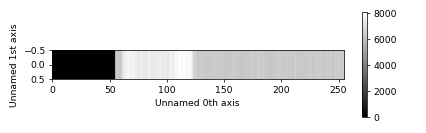

<IPython.core.display.Javascript object>


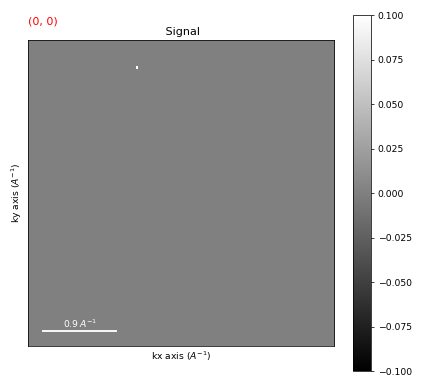

[########################################] | 100% Completed |  0.3s


<IPython.core.display.Javascript object>


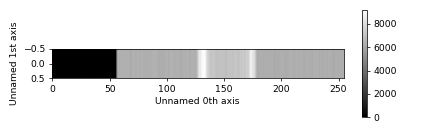

<IPython.core.display.Javascript object>


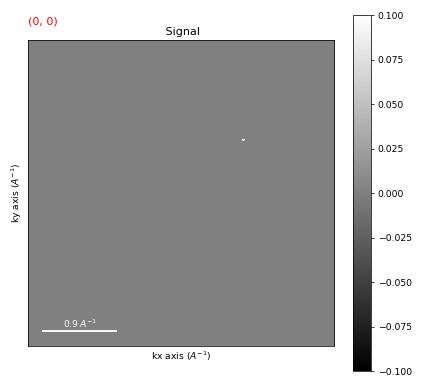

[########################################] | 100% Completed |  0.3s


<IPython.core.display.Javascript object>


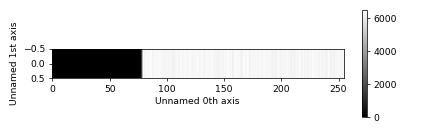

<IPython.core.display.Javascript object>


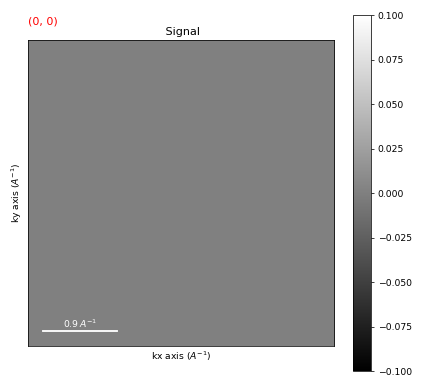

[########################################] | 100% Completed |  0.3s


<IPython.core.display.Javascript object>


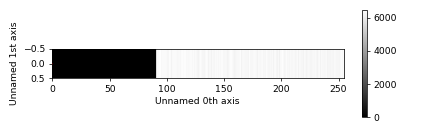

<IPython.core.display.Javascript object>


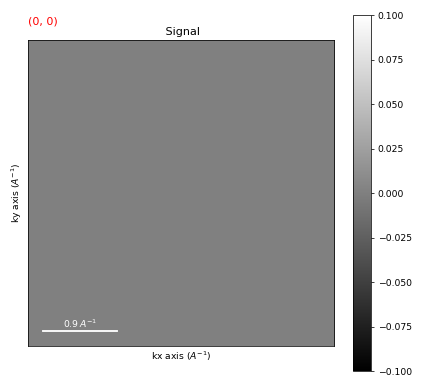

[########################################] | 100% Completed |  0.3s


<IPython.core.display.Javascript object>


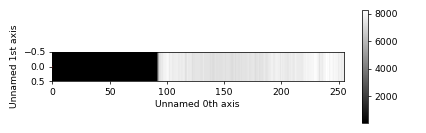

<IPython.core.display.Javascript object>


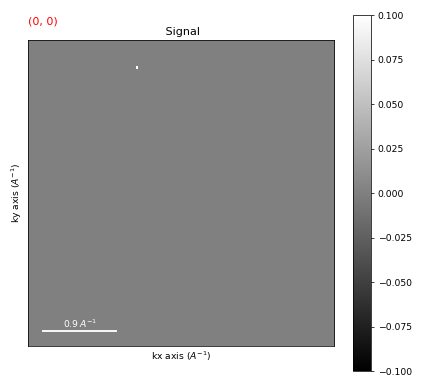

[########################################] | 100% Completed |  0.3s


<IPython.core.display.Javascript object>


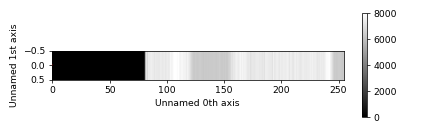

<IPython.core.display.Javascript object>


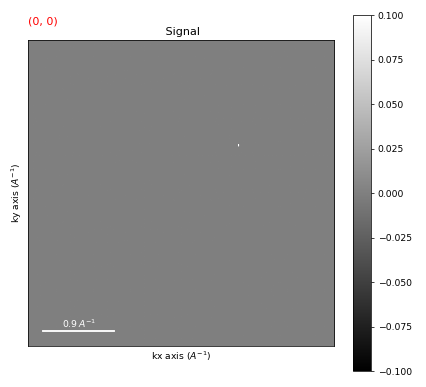

[########################################] | 100% Completed |  0.3s


<IPython.core.display.Javascript object>


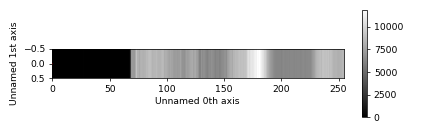

<IPython.core.display.Javascript object>


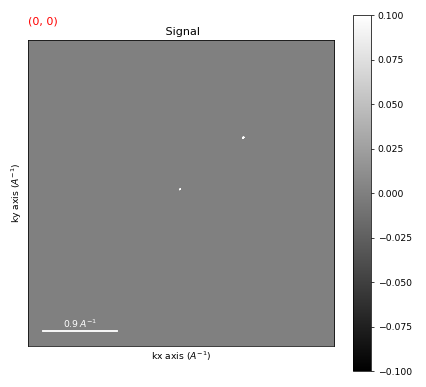

[########################################] | 100% Completed |  0.3s


<IPython.core.display.Javascript object>


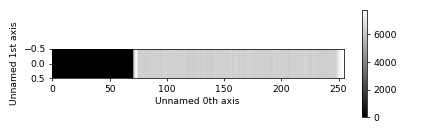

<IPython.core.display.Javascript object>


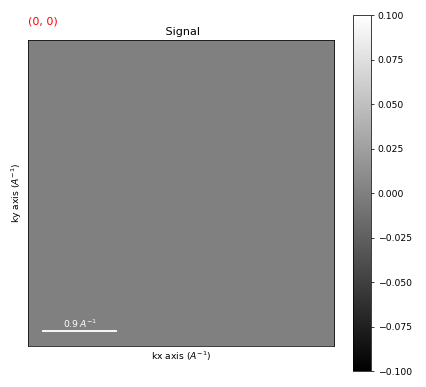

[########################################] | 100% Completed |  0.3s


<IPython.core.display.Javascript object>


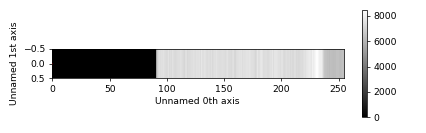

<IPython.core.display.Javascript object>


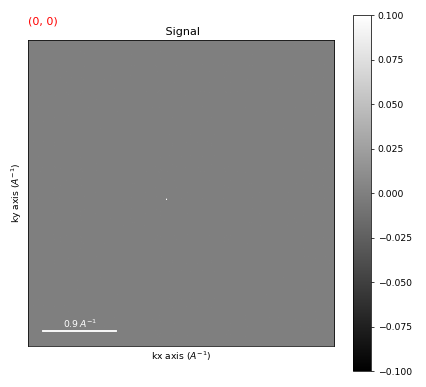

[########################################] | 100% Completed |  0.3s


<IPython.core.display.Javascript object>


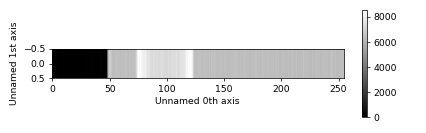

<IPython.core.display.Javascript object>


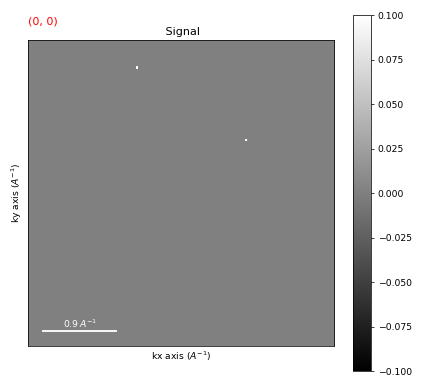

[########################################] | 100% Completed |  0.3s


<IPython.core.display.Javascript object>


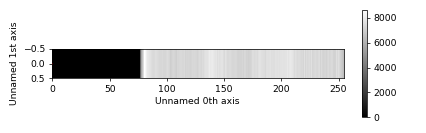

<IPython.core.display.Javascript object>


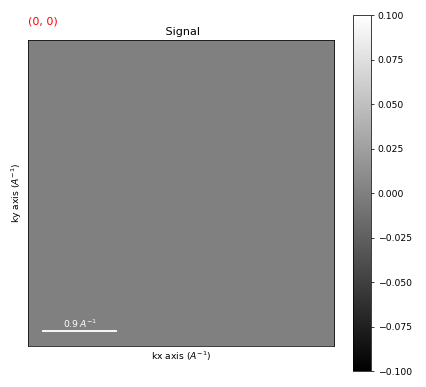

[########################################] | 100% Completed |  0.3s


<IPython.core.display.Javascript object>


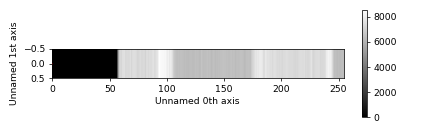

<IPython.core.display.Javascript object>


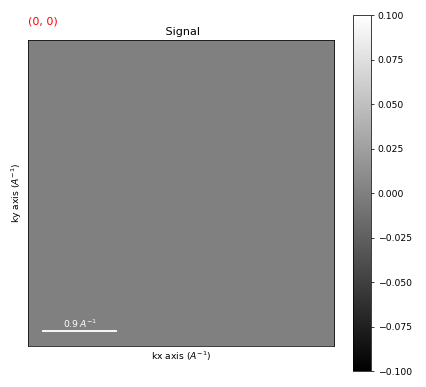

[########################################] | 100% Completed |  0.3s


<IPython.core.display.Javascript object>


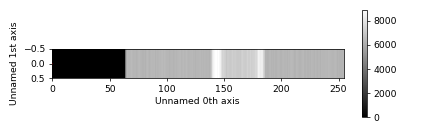

<IPython.core.display.Javascript object>


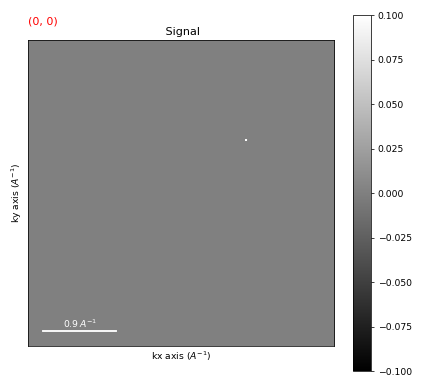

[########################################] | 100% Completed |  0.3s


<IPython.core.display.Javascript object>


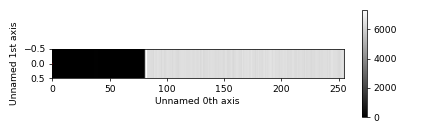

<IPython.core.display.Javascript object>


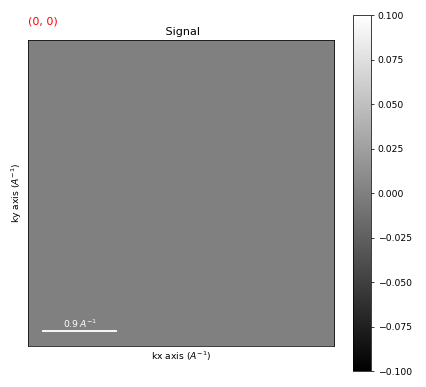

[########################################] | 100% Completed |  0.3s


<IPython.core.display.Javascript object>


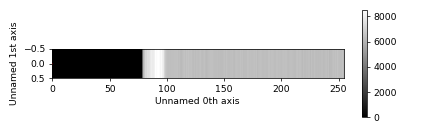

<IPython.core.display.Javascript object>


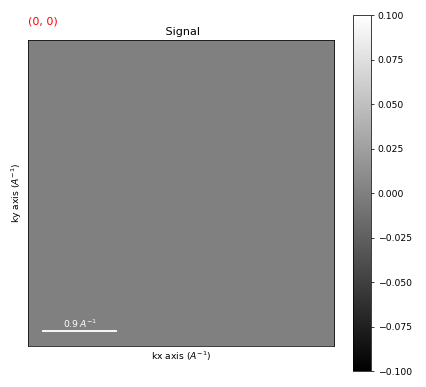

[########################################] | 100% Completed |  0.3s


<IPython.core.display.Javascript object>


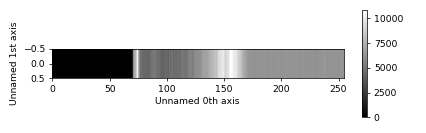

<IPython.core.display.Javascript object>


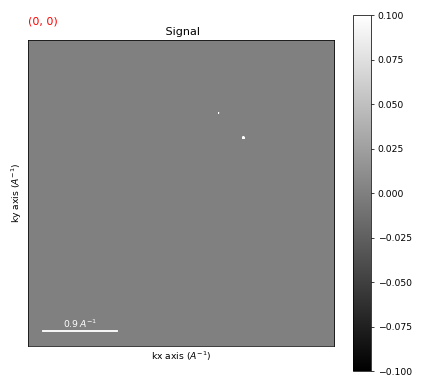

[########################################] | 100% Completed |  0.3s


<IPython.core.display.Javascript object>


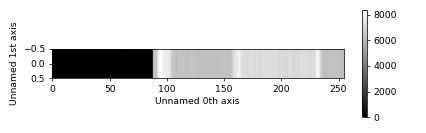

<IPython.core.display.Javascript object>


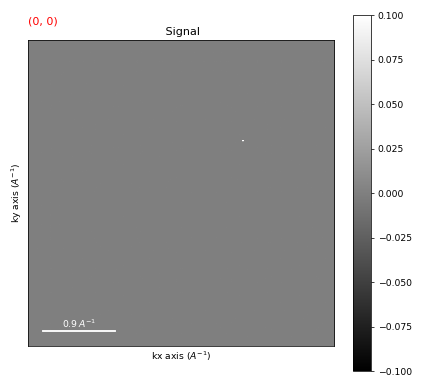

In [23]:
for dp in dps:
    ds = hs.load(dp, lazy = True)
    ds.inav[:,:1].plot()

[########################################] | 100% Completed |  0.3s


<IPython.core.display.Javascript object>


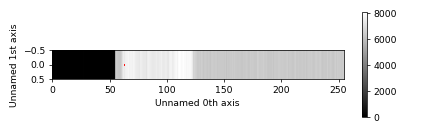

<IPython.core.display.Javascript object>


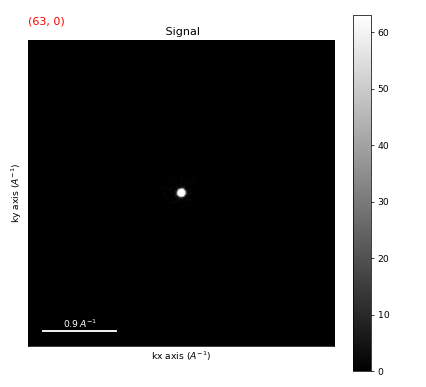

In [20]:
sample.raw_data.inav[:,:1].plot()

In [15]:
bad_pattern = nds[0].compute()

In [18]:
data_manip_lowq_resized(bad_pattern[None,:,:])

started data manipulations
resized
1


array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)

In [9]:
input_data.shape

(64770, 128, 128)

In [52]:
vae_model = create_vae_model(hparams)
old_model = create_vae_model(hparams)


info = {}

info[sample_name] = {'rebin': rebin_factor, 'hparams':hparams}

old_model_path = old_model_weights
old_model.load_weights(old_model_path)


def transfer_layer_weights(old_model, new_model, enc_layer_list, dec_layer_list):
    for l in enc_layer_list:
        w = old_model.get_layer(index = 0).get_layer(index=l).get_weights()
        new_model.get_layer(index = 0).get_layer(index=l).set_weights(w)

    for l in dec_layer_list:
        w = old_model.get_layer(index = 1).get_layer(index=l).get_weights()
        new_model.get_layer(index = 1).get_layer(index=l).set_weights(w)
    return new_model

enc_layer_list = list(range(5,7))

dec_layer_list = list(range(7,10))

vae_model = transfer_layer_weights(old_model, vae_model, enc_layer_list, dec_layer_list)

In [53]:


history = vae_model.fit(train_gen, validation_data=valid_gen, epochs=1, callbacks= [chkpoint_model])


 6/32 [====>.........................] - ETA: 12s - loss: nan

KeyboardInterrupt: 

In [ ]:
old_model_preds = old_model.predict_on_batch(train_gen)

In [57]:
old_model_preds.shape

(2048, 128, 128, 1)

In [81]:
ind = 50

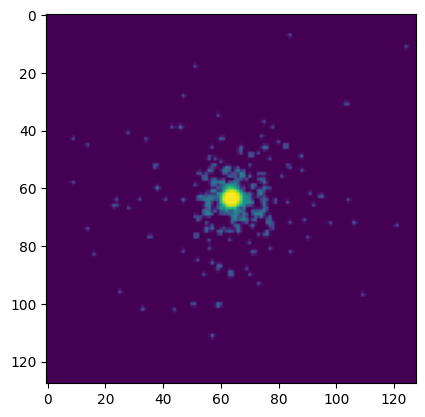

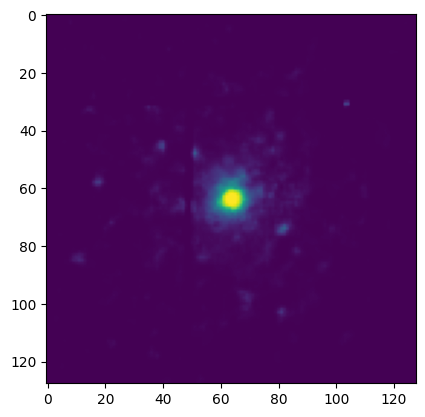

In [82]:
plt.figure()
plt.imshow(train_gen[0][0][ind,:,:,0])
plt.figure()
plt.imshow(old_model_preds[ind,:,:,0])